In [2]:
import re
import contextlib
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from collections import defaultdict
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from collections import defaultdict
import matplotlib.pyplot as plt

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

def clean_text(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

def tokenize_document(document):
    tokens = word_tokenize(document)
    return tokens

def filter_nouns(tokens):
    # load the English language model
    nlp = spacy.load("en_core_web_sm")
    
    # join the tokens into a single text string
    text = ' '.join(tokens)
    
    # process the text with spaCy
    doc = nlp(text)
    
    # extract nouns ('NN' tags)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    
    return nouns

def get_most_frequent_words(corpus, dictionary):
    # Initialize a defaultdict to hold the frequency of each word
    frequency = defaultdict(int)
    
    # Iterate over each document in the corpus
    for doc in corpus:
        # Iterate over each word and its count in the document
        for word_id, count in doc:
            # Add the count to the word's frequency
            frequency[dictionary[word_id]] += count
    
    # Sort the words by frequency in descending order and return them
    sorted_words = sorted(frequency.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_words

WORDS_FILTER = ['iphone',
'phone',
'apple',
'mobile',
'product',
'flipkart']

In [3]:
# read file
df = pd.read_csv('data/APPLE_iPhone_SE.csv')

# clean text
df['Comment'] = df['Comment'].apply(clean_text)
df['Reviews'] = df['Reviews'].apply(clean_text)

# remove 'read more' from reviews
df['Reviews'] = df['Reviews'].apply(lambda x: x.replace('read more', ''))

In [4]:
# tokenize
token_docs = []
for doc in df['Reviews']:
    token_docs.append(tokenize_document(doc))
print(token_docs[0])

['great', 'camera', 'for', 'pics', 'and', 'videos', 'battery', 'life', 'is', 'good', 'so', 'far', 'with', 'some', 'setting', 'turn', 'of', 'which', 'i', 'never', 'use', 'and', 'when', 'i', 'use', 'i', 'turn', 'those', 'on', 'and', 'i', 'use', 'it', 'in', 'power', 'saving', 'mode', 'all', 'the', 'time', 'so', 'a', 'full', 'day', 'with', 'light', 'gaming', 'of', 'hr', 'or', 'more', 'using', 'camera', 'for', 'hr', 'or', 'more', 'listening', 'music', 'in', 'my', 'car', 'on', 'youtube', 'and', 'bluetooth', 'on', 'for', 'couple', 'of', 'hours', 'it', 'gives', 'me', 'full', 'day', 'of', 'battery', 'varing', 'from', 'to', 'hours', 'sot', 'per', 'dayperformance', 'is', 'top', 'notch', 'plays', 'every', 'game', 'and', 'every', 'task', 'with', 'easevery', 'premium', 'phone', 'look']


In [5]:
# remove stopwords, filter words
nltk.download('stopwords')

stop_words = stopwords.words('english')
documents_no_stop = []
for doc in tqdm(token_docs): # each doc is a list of words
    # loop through each word and filter
    words_filter = [word for word in doc if word not in stop_words and word not in WORDS_FILTER] 

    # append to new list of lists
    documents_no_stop.append(words_filter)

print(documents_no_stop[0])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leocb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 9713/9713 [00:00<00:00, 49946.15it/s]

['great', 'camera', 'pics', 'videos', 'battery', 'life', 'good', 'far', 'setting', 'turn', 'never', 'use', 'use', 'turn', 'use', 'power', 'saving', 'mode', 'time', 'full', 'day', 'light', 'gaming', 'hr', 'using', 'camera', 'hr', 'listening', 'music', 'car', 'youtube', 'bluetooth', 'couple', 'hours', 'gives', 'full', 'day', 'battery', 'varing', 'hours', 'sot', 'per', 'dayperformance', 'top', 'notch', 'plays', 'every', 'game', 'every', 'task', 'easevery', 'premium', 'look']


In [6]:
len(documents_no_stop)

9713

In [5]:
# lemmatize
from nltk.stem import WordNetLemmatizer

def lemmatize_doc(document):
    lemmatizer = WordNetLemmatizer()
    document_lemmatized = []
    for word in document:
        document_lemmatized.append(lemmatizer.lemmatize(word))

    return document_lemmatized

docs_lemmatized = []

for doc in documents_no_stop:
    docs_lemmatized.append(lemmatize_doc(doc))

print(docs_lemmatized[0])

['great', 'camera', 'pic', 'video', 'battery', 'life', 'good', 'far', 'setting', 'turn', 'never', 'use', 'use', 'turn', 'use', 'power', 'saving', 'mode', 'time', 'full', 'day', 'light', 'gaming', 'hr', 'using', 'camera', 'hr', 'listening', 'music', 'car', 'youtube', 'bluetooth', 'couple', 'hour', 'give', 'full', 'day', 'battery', 'varing', 'hour', 'sot', 'per', 'dayperformance', 'top', 'notch', 'play', 'every', 'game', 'every', 'task', 'easevery', 'premium', 'look']


In [22]:
# export treated and lemmatized docs
df_lemmatized = pd.DataFrame(columns=["Ratings","Comment","Review_tokens"])
df_lemmatized["Ratings"] = df["Ratings"]
df_lemmatized["Comment"] = df["Comment"]
df_lemmatized["Review_tokens"] = pd.Series(docs_lemmatized)

df_lemmatized.to_parquet('data/df_lemmatized.parquet')

In [6]:
# filter nouns
def filter_nouns(tokens):
    # load the English language model
    nlp = spacy.load("en_core_web_sm")
    
    # join the tokens into a single text string
    text = ' '.join(tokens)
    
    # process the text with spaCy
    doc = nlp(text)
    
    # extract nouns ('NN' tags)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    
    return nouns

num_cores = 15

with tqdm_joblib(tqdm(desc="Noun filtering",total=len(docs_lemmatized))) as progress_bar:
    filtered_nouns = Parallel(n_jobs=num_cores)(
        delayed(filter_nouns)(tokens) for tokens in docs_lemmatized
    )

# save filtered nouns
with open('data/filtered_nouns.txt', 'w') as f:
    for nouns in filtered_nouns:
        # Join the nouns into a single string with spaces between each noun
        nouns_str = ' '.join(nouns)
        
        # Write the string to the file and add a newline character at the end
        f.write(nouns_str + '\n')

Noun filtering: 100%|██████████| 9713/9713 [11:35<00:00, 13.96it/s]


In [5]:
filtered_nouns = []

with open('data/filtered_nouns.txt', 'r') as f:
    for line in f:
        # Split the line into nouns and add it to the list
        nouns = line.strip().split()
        filtered_nouns.append(nouns)

In [15]:
# get highest frequency words
dictionary = corpora.Dictionary(filtered_nouns)
bow = [dictionary.doc2bow(doc) for doc in tqdm(filtered_nouns, desc="doc2bow")]

# create a frequency distribution
frequency = defaultdict(int)
for text in bow:
    for token_id, freq in text:
        frequency[dictionary[token_id]] += freq

# sort the frequency distribution in descending order
sorted_frequency = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

# print the words with the highest frequency
for word, freq in sorted_frequency:
    print(f'{word}: {freq}')

# to excel
df_word_freq = pd.DataFrame(sorted_frequency, columns=["Word", "Frequency"])
df_word_freq.to_excel("data/word_freq.xlsx")

doc2bow: 100%|██████████| 9713/9713 [00:00<00:00, 267857.66it/s]


battery: 2715
camera: 1239
performance: 1200
day: 751
price: 746
money: 652
quality: 550
value: 502
size: 484
screen: 449
user: 447
time: 430
life: 414
display: 402
use: 389
backup: 357
delivery: 331
issue: 320
device: 313
budget: 268
love: 263
thanks: 244
usage: 241
hour: 234
phone: 233
thing: 232
experience: 226
charger: 208
feature: 186
superb: 184
hand: 183
problem: 178
processor: 176
deal: 174
chip: 173
video: 170
range: 170
charge: 168
people: 167
month: 165
year: 149
beast: 146
buy: 138
bit: 136
work: 134
power: 131
purchase: 131
call: 127
hr: 126
sale: 126
game: 122
design: 119
u: 117
review: 116
drain: 116
service: 114
need: 106
lot: 105
mode: 99
model: 99
look: 93
product: 93
k: 92
capacity: 88
r: 88
night: 87
premium: 85
gaming: 84
android: 81
week: 80
speed: 80
photo: 78
speaker: 78
brand: 76
touch: 73
offer: 72
io: 68
rest: 67
bionic: 66
point: 65
good: 64
option: 63
class: 63
picture: 61
software: 61
notch: 60
inch: 60
iphones: 60
apps: 59
pocket: 59
light: 57
thank: 56
c

In [16]:
import random

# get sentences with a given word
def get_sentence_with_word(word, docs):
    sentences = []
    for doc in docs:
        if word in doc:
            sentences.append(' '.join(doc))
    
    return sentences

sentences = get_sentence_with_word("backup", token_docs)

# print the first sentence
print(sentences[0])

# select 100 random sentences
random_sentences = random.sample(sentences, 100)

# write the sentences to a text file
with open('data/sentences_backup.txt', 'w') as f:
    for sentence in random_sentences:
        f.write("%s\n" % sentence)


people talk about its battery backup man im in love with this handset so clean so smooth smoother than xr if youve used both youll understand camera better than xr battery of xr is better but still ill vote for se because of a bionic chip touch haptics and many more reasons its a beast in this segment still i want you all to feel this beast in your hand sexy as it looks just a perfect masterpiece


In [21]:
# bigrams frequency of whole dictionary (not just nouns)
from nltk import bigrams
from collections import defaultdict

# create a frequency distribution
frequency = defaultdict(int)
for text in docs_lemmatized:
    for word1, word2 in bigrams(text):
        frequency[(word1, word2)] += 1

# sort the frequency distribution in descending order
sorted_frequency = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

# print the words with the highest frequency
for words, freq in sorted_frequency:
    print(f'{words}: {freq}')

# to excel
df_bigram_freq = pd.DataFrame(sorted_frequency, columns=["Bigram", "Frequency"])
df_word_freq.to_excel("data/bigram_freq.xlsx")

('battery', 'life'): 316
('battery', 'backup'): 278
('value', 'money'): 265
('good', 'battery'): 162
('except', 'battery'): 135
('camera', 'quality'): 129
('big', 'billion'): 121
('battery', 'performance'): 107
('good', 'camera'): 105
('battery', 'drain'): 93
('screen', 'size'): 93
('camera', 'good'): 86
('bionic', 'chip'): 85
('performance', 'good'): 85
('small', 'screen'): 80
('heavy', 'user'): 79
('price', 'range'): 77
('overall', 'good'): 75
('billion', 'day'): 74
('one', 'best'): 73
('good', 'performance'): 68
('best', 'price'): 64
('small', 'size'): 63
('first', 'time'): 61
('battery', 'good'): 61
('camera', 'performance'): 61
('really', 'good'): 60
('best', 'budget'): 59
('screen', 'time'): 58
('battery', 'back'): 58
('also', 'good'): 54
('last', 'day'): 53
('issue', 'battery'): 53
('dont', 'buy'): 53
('battery', 'capacity'): 52
('everything', 'good'): 51
('battery', 'last'): 51
('great', 'camera'): 49
('little', 'bit'): 49
('top', 'notch'): 48
('performance', 'camera'): 48
('gr

In [11]:
### LDA
def lda_model(documents,dictionary,**kwargs):
    dictionary = corpora.Dictionary(dictionary)
    corpus = [dictionary.doc2bow(doc) for doc in tqdm(documents, desc="Building corpus")]

    lda_model = LdaModel(corpus=corpus, id2word=dictionary,**kwargs)

    # Print the topics
    topics = lda_model.print_topics()
    print("Topics:")
    for topic in topics:
        print(topic)

    # Get and print the topics for each document
    document_topics = []
    for i, doc in enumerate(corpus):
        doc_topics = lda_model.get_document_topics(doc)
        doc_topics.sort(key=lambda x: x[1], reverse=True)  # Sort by topic weight
        top_topics = doc_topics[:2]  # Get top 2 topics
        document_topics.append(top_topics)
        print(f"Document {i+1} top topics: {top_topics}")

    return topics, document_topics

# apply synonyms
synonyms_nouns = [['screen' if word == 'display' else word for word in sublist] for sublist in filtered_nouns]
synonyms_nouns = [['charger' if (word == 'charge' or word == 'charging') else word for word in sublist] for sublist in synonyms_nouns]
synonyms_nouns = [['photo' if (word == 'video' or word == 'photography') else word for word in sublist] for sublist in synonyms_nouns]

topics_to_model = [[topic] for topic in ["battery", "camera", "price", "screen", "charger", "gaming", "photo"]]
topics, document_topics = lda_model(filtered_nouns, topics_to_model,
                                     num_topics=len(topics_to_model),random_state=123)

Building corpus:   0%|          | 0/9713 [00:00<?, ?it/s]

Building corpus: 100%|██████████| 9713/9713 [00:00<00:00, 304165.17it/s]


Topics:
(0, '0.707*"camera" + 0.262*"battery" + 0.021*"screen" + 0.008*"price" + 0.002*"gaming" + 0.001*"photo" + 0.000*"charger"')
(1, '0.599*"photo" + 0.249*"camera" + 0.083*"battery" + 0.030*"price" + 0.019*"gaming" + 0.017*"screen" + 0.003*"charger"')
(2, '0.984*"battery" + 0.007*"camera" + 0.004*"price" + 0.003*"charger" + 0.001*"gaming" + 0.000*"screen" + 0.000*"photo"')
(3, '0.802*"screen" + 0.080*"gaming" + 0.072*"battery" + 0.033*"price" + 0.007*"camera" + 0.005*"photo" + 0.001*"charger"')
(4, '0.632*"battery" + 0.125*"gaming" + 0.124*"price" + 0.061*"screen" + 0.047*"camera" + 0.009*"photo" + 0.001*"charger"')
(5, '0.842*"price" + 0.130*"battery" + 0.016*"camera" + 0.010*"screen" + 0.001*"charger" + 0.001*"photo" + 0.000*"gaming"')
(6, '0.583*"charger" + 0.331*"battery" + 0.066*"camera" + 0.007*"price" + 0.007*"gaming" + 0.004*"photo" + 0.003*"screen"')
Document 1 top topics: [(4, 0.44629708), (0, 0.4343937)]
Document 2 top topics: [(0, 0.5711591), (1, 0.07160967)]
Document 3

In [12]:
# sentiment analysis of each document
nltk.download('vader_lexicon')

# initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

sentiment_scores = []

for doc in docs_lemmatized:
    # join the list of words into a single string
    doc_text = ' '.join(doc)

    # get the sentiment scores for the document
    sentiment_scores.append(sid.polarity_scores(doc_text))

print(sentiment_scores[1])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\leocb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.9917}


In [13]:
# get (topic_index,sentiment,topic word list) list
topics_sentiment = []

for i in range(len(docs_lemmatized)):
    topics_sentiment.append((document_topics[i][0][0], sentiment_scores[i]["compound"],topics[document_topics[i][0][0]][1]))

print(topics_sentiment[0])

# get statistics for each topic
df_topics = pd.DataFrame(topics_sentiment, columns=["Topic_index", "Sentiment", "Topics"])
df_topics.groupby("Topic_index").describe()

(4, 0.8807, '0.632*"battery" + 0.125*"gaming" + 0.124*"price" + 0.061*"screen" + 0.047*"camera" + 0.009*"photo" + 0.001*"charger"')


Sentiment                                                       \
                count      mean       std     min     25%     50%      75%   
Topic_index                                                                  
0              7134.0  0.491802  0.336989 -0.9214  0.4215  0.5719  0.71840   
1                57.0  0.701765  0.369571 -0.5423  0.6486  0.8481  0.92990   
2              1523.0  0.364302  0.492904 -0.9360  0.0000  0.4767  0.77170   
3               227.0  0.535921  0.449959 -0.7430  0.3343  0.7351  0.88205   
4                65.0  0.646206  0.417925 -0.8481  0.5965  0.8271  0.93220   
5               558.0  0.607166  0.325623 -0.9062  0.4404  0.6486  0.85550   
6               149.0  0.395074  0.435107 -0.8225  0.0000  0.4588  0.79060   

                     
                max  
Topic_index          
0            0.9917  
1            0.9875  
2            0.9860  
3            0.9769  
4            0.9890  
5            0.9934  
6            0.9834

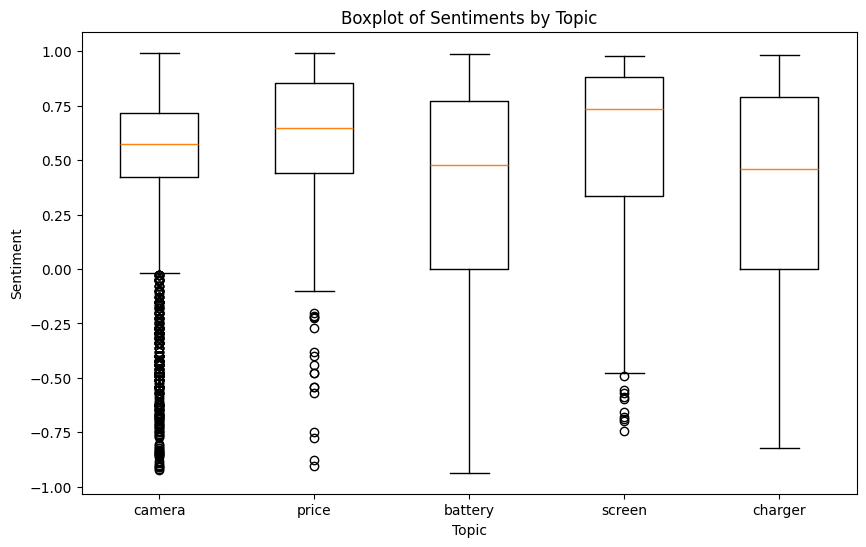

In [19]:
# choose main topics by count
topics_index_name = {0:"camera",2:"battery",3:"screen",5:"price",6:"charger"}

# filter df to only include rows where Topic_index is in topics_index_name
df_topics = df_topics[df_topics['Topic_index'].isin(topics_index_name.keys())]

# replace the Topic_index with its corresponding name
df_topics['Topic_index'] = df_topics['Topic_index'].map(topics_index_name)

# Create boxplot
plt.figure(figsize=(10,6))
plt.boxplot([df_topics[df_topics['Topic_index'] == topic]['Sentiment'] for topic in df_topics['Topic_index'].unique()], labels=df_topics['Topic_index'].unique())
plt.title('Boxplot of Sentiments by Topic')
plt.xlabel('Topic')
plt.ylabel('Sentiment')
plt.show()